# Bootstrap
Reference: Hansen (2018), Kevin Sheppard's lecture notes (2014), class slides, Andrew Patton's Matlab implementation of the optimal block length as in Politis, White, and Patton (2009).

Content:

* (1) [Bootstrap EDFs](#section1)
* (2) [Bootstrap IID](#section2)
* (3) [Bootstrap dependence](#section3)
* (4) [Bootstrap regression](#section4)
* (5) [Bootstrap AR(1)](#section5)
* (6) [Boostrapped confidence intervals](#section6)

<a id='section1'></a>
## (1) Bootstrap EDFs

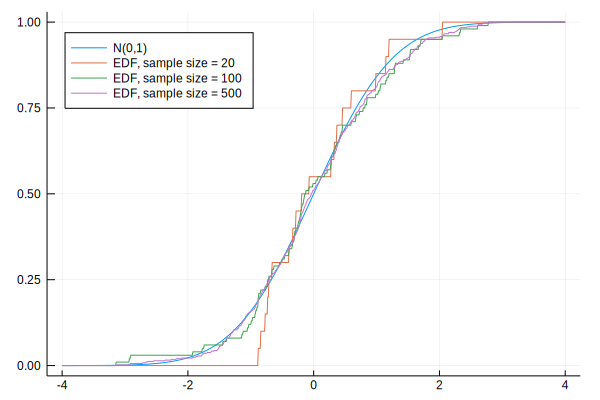

In [1]:
using Plots: plot
using Distributions: Normal, cdf, ecdf
using Random

Random.seed!(123)

N = 500

X0 = -4:0.01:4
F0 = cdf.(Normal(), X0)
X = rand(Normal(), N)

# `ecdf` returns a function calculating the empirical CDF
F20 = ecdf(X[1:20])(X0) 
F100 = ecdf(X[1:100])(X0)
F500 = ecdf(X[1:500])(X0) 

# Empirical distribution function, different sample size
plot(X0,
    [F0 F20 F100 F500],
    label=
    ["N(0,1)", "EDF, sample size = 20",
        "EDF, sample size = 100",
        "EDF, sample size = 500"], legend=:topleft)

-----------

<a id='section2'></a>
## (2) Bootstrap IID

In [2]:
using Statistics: mean, std, quantile, cor
using Distributions: Normal
using Random

Random.seed!(123)

B = 50000 # Number of bootstrap replications
T = 100
X = rand(Normal(), T)

function print_bs(x, mu)
    out = """
    Bootstrap
    Mean: $(round(mean(x), digits=4))
    SE: $(round(std(x, corrected=false), digits=4))
    Bias: $(round(mean(x) - mu, digits=4))
    2.5%, 97.5% percentiles
    $(round(quantile(x, 0.025), digits=4)), $(round(quantile(x, 0.975), digits=4))
    """
    
    println(out)
end

print_bs (generic function with 1 method)

### (2-A) IID Bootstrap

In [3]:
mu_bs_iid = zeros(B)
for b in 1:B
    u = rand(1:T, T)
    x_bs_iid = X[u]
    mu_bs_iid[b] = mean(x_bs_iid)
end

print_bs(mu_bs_iid, mean(X))

Bootstrap
Mean: 0.0349
SE: 0.1119
Bias: -0.0018
2.5%, 97.5% percentiles
-0.1857, 0.2528



Another way of writing the very common pattern above, is to use the `map` function, which applies a function to each element in a collection. For example, the following computes the square of the first 3 integers:

In [4]:
map(x -> x^2, 1:3)

3-element Array{Int64,1}:
 1
 4
 9

When just doing something that does not take any arguments, an underscore is usually used to make this clear:

In [5]:
map(_ -> rand(), 1:3)

3-element Array{Float64,1}:
 0.4911517847890061
 0.5054702852310085
 0.9542793391210136

So the same IID bootstrap can simply be written as

In [6]:
Random.seed!(123)
X = rand(Normal(), T)

iid_bs = map(_ -> mean(X[rand(1:T, T)]), 1:B)

print_bs(iid_bs, mean(X))

Bootstrap
Mean: 0.0349
SE: 0.1119
Bias: -0.0018
2.5%, 97.5% percentiles
-0.1857, 0.2528



### (2-B) IID bootstrap with balanced resampling

In [7]:
xRepl = repeat(X, 1, B)
u = randperm(T * B)
bal_bs = zeros(B)
for b in 1:B
    ind = T * (b-1) .+ (1:T)
    xb = xRepl[u[ind]]
    bal_bs[b] = mean(xb)
end

print_bs(bal_bs, mean(X))

Bootstrap
Mean: 0.0367
SE: 0.1124
Bias: -0.0
2.5%, 97.5% percentiles
-0.1837, 0.257



In [8]:
# Written another way:
U = reshape(u, T, B)
bal_bs = map(v -> mean(xRepl[U[:,v]]), 1:B)

print_bs(bal_bs, mean(X))

Bootstrap
Mean: 0.0367
SE: 0.1124
Bias: -0.0
2.5%, 97.5% percentiles
-0.1837, 0.257



### (2-C) IID bootstrap with antithetic resampling

In [9]:
ant_bs = zeros(B)
x = sort(X)
for b in 1:2:B
    u = rand(1:T)
    xStar = x[u]
    ant_bs[b] = mean(xStar)
    u = T - u + 1
    xStar = x[u]
    ant_bs[b+1] = mean(xStar)
end

print_bs(ant_bs, mean(X))

Bootstrap
Mean: 0.0359
SE: 1.123
Bias: -0.0008
2.5%, 97.5% percentiles
-2.9155, 2.333



In [10]:
cor(ant_bs[1:2:B],
    ant_bs[2:2:B])

-0.9820580393044706

--------------------

<a id='section3'></a>
## (3) Bootstrap dependence

In [11]:
using Statistics: mean, std, quantile
using Distributions: Normal, Exponential
using Base.Iterators: flatten
using Random

Random.seed!(123)

B = 50000 # Number of bootstrap replications
# AR(1) data
μ = 0
σ = 1
α₁ = 0.5
α₀ = μ * (1 - α₁)
T = 100
ϵ = rand(Normal(), T)
y = zeros(T)
y[1] = α₀ + ϵ[1] * sqrt(1 / (1 - α₁^2))
for t=2:T
    y[t] = 0.5 * y[t-1] + ϵ[t]
end

function print_bs(x, mu)
    out = """
    Bootstrap
    Mean: $(round(mean(x), digits=4))
    SE: $(round(std(x, corrected=false), digits=4))
    Bias: $(round(mean(x) - mu, digits=4))
    2.5%, 97.5% percentiles
    $(round(quantile(x, 0.025), digits=4)), $(round(quantile(x, 0.975), digits=4))
    """
    
    println(out)
end

print_bs (generic function with 1 method)

### (3-A) IID bootstrap

In [12]:
iid_bs = map(_ -> mean(y[rand(1:T, T)]), 1:B)

print_bs(iid_bs, mean(y))

Bootstrap
Mean: 0.0849
SE: 0.1227
Bias: -0.0015
2.5%, 97.5% percentiles
-0.1548, 0.3246



### (3-B) Moving block bootstrap

In [13]:
rand_mb = function(N::Int, m::Int)
    N > m || error("Range does not make sense")
    nblocks = Int(ceil(N/m))
    startidx = rand(1:N-m+1, nblocks)
    ranges = map(v -> v:v+m-1, startidx)

    # [1:N]: truncates if the particular (N, m)
    # combination gives more than N ranges...
    collect(flatten(ranges))[1:N]
end

#13 (generic function with 1 method)

In [14]:
# block size
m = 5

mb_bs = map(_ -> mean(y[rand_mb(T, m)]), 1:B)

print_bs(mb_bs, mean(y))

Bootstrap
Mean: 0.0522
SE: 0.1599
Bias: -0.0342
2.5%, 97.5% percentiles
-0.2579, 0.3699



Where the block size comes from

In [15]:
# imports Julia `opt_block_length` as Andrew Patton's Matlab implementation
include("src/opt_block_length.jl")
mb = zeros(5000, 2)
X = zeros(100, 5000)
for b in 1:5000
    ϵ = rand(Normal(), T)
    y = zeros(T)
    y[1] = α₀ + ϵ[1] * sqrt(1 / (1 - α₁^2))
    for t=2:T
        y[t] = 0.5 * y[t-1] + ϵ[t]
    end
    X[:, b] = y
    mb[b, :] = opt_block_length(y)
end

# Average optimal block length, stationary and circular
mean(mb, dims=1)

1×2 Array{Float64,2}:
 5.05195  5.69819

### (3-C) Circular bootstrap

In [16]:
rand_cb = function(N::Int, m::Int)
    N > m || error("Range does not make sense")
    nblocks = Int(ceil(N/m))
    startidx = rand(1:N, nblocks)
    ranges = map(v -> v:v+m-1, startidx)

    out = collect(flatten(ranges))[1:N] .% N
    out[out .== 0] .= N # since mod(N) = 0
    out
end

#23 (generic function with 1 method)

In [17]:
cb_bs = map(_ -> mean(y[rand_cb(T, m)]), 1:B)

print_bs(cb_bs, mean(y))

Bootstrap
Mean: 0.0696
SE: 0.1446
Bias: -0.0002
2.5%, 97.5% percentiles
-0.2192, 0.3499



### (3-D) Stationary bootstrap

In [18]:
rand_m(m) =
    Int(ceil(rand(Exponential(m))))

rand_m (generic function with 1 method)

In [19]:
st_bs = map(_ -> mean(y[rand_cb(T, rand_m(m))]), 1:B)

print_bs(st_bs, mean(y))

Bootstrap
Mean: 0.0691
SE: 0.1352
Bias: -0.0008
2.5%, 97.5% percentiles
-0.2003, 0.3308



In [20]:
yRepl = [y; y]
u = zeros(T)
mustar = zeros(B)
for b in 1:B
    u[1] = ceil(T*rand())
    for t in 2:T
        if rand() < 1/m
            u[t] = ceil(T*rand())
        else
            u[t] = u[t-1] + 1
        end
    end
    yStar = yRepl[Int.(u)]
    mustar[b] = mean(yStar)
end

print_bs(mustar, mean(y))

Bootstrap
Mean: 0.0696
SE: 0.1368
Bias: -0.0002
2.5%, 97.5% percentiles
-0.202, 0.3344



------------

<a id='section4'></a>
## (4) Bootstrap regression

In [21]:
using Statistics: mean, std, quantile
using Distributions: Normal
using LinearAlgebra: diag
using Random

Random.seed!(123)

B = 50000 # Number of bootstrap replications
T = 100
x = rand(Normal(), T, 2)
e = rand(Normal(), T)
y = sum(x, dims=2) + e
beta = x \ y
ε = y - x * beta
olsVCV = ε' * ε / T .* inv(x' * x)

# OLS parameters
beta

2×1 Array{Float64,2}:
 0.8593501050569382
 0.917464368446246 

In [22]:
# OLS SEs
sqrt.(diag(olsVCV))

2-element Array{Float64,1}:
 0.0924485497895453 
 0.10416470962577389

### (4-A) Parametric regression bootstrap

In [23]:
betab = zeros(B, length(beta))
for b in 1:B
    xb = x[rand(1:T, T), :]
    eb = ε[rand([1:T, T])]
    yb = xb * beta .+ eb
    
    betab[b, :] = xb \ yb
end

In [24]:
berr = betab .- beta'
bVCV = berr' * berr / B

# Average bootstrap params
mean(betab, dims=1)'

2×1 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.8434964423312937
 0.8386289428290242

In [25]:
# Bootstrapped SEs
sqrt.(diag(bVCV))

2-element Array{Float64,1}:
 0.1144768707386265 
 0.16521502155551043

In [26]:
# Bias
mean(betab, dims=1)' - beta

2×1 Array{Float64,2}:
 -0.01585366272564448
 -0.07883542561722179

### (4-A) Non-parametric regression bootstrap

In [27]:
betab = zeros(B, length(beta))
for b in 1:B
    u = rand(1:T, T)
    xb = x[u, :]
    yb = y[u]
    
    betab[b, :] = xb \ yb
end

In [28]:
berr = betab .- beta'
bVCV = berr' * berr / B

# Average bootstrap params
mean(betab, dims=1)'

2×1 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.8653700651011593
 0.9148738326366928

In [29]:
# Bootstrapped SEs
sqrt.(diag(bVCV))

2-element Array{Float64,1}:
 0.09838045447796237
 0.11008888115590033

In [30]:
# Bias
mean(betab, dims=1)' - beta

2×1 Array{Float64,2}:
  0.006019960044221118 
 -0.0025905358095532627

----------------

<a id='section5'></a>
## (5) Bootstrap AR(1)

In [31]:
using Statistics: mean, std, quantile
using Distributions: Normal
using LinearAlgebra: diag
using Random

Random.seed!(123)

B = 50000 # Number of bootstrap replications
# AR(1) data
μ = 0
σ = 1
α₁ = 0.5
α₀ = μ * (1 - α₁)
T = 100
ϵ = sqrt(σ * (1 - α₁^2)) * rand(Normal(), T)
y = zeros(T)
y[1] = α₀ + ϵ[1] / sqrt(1 - α₁^2)
for t=2:T
    y[t] = α₁ * y[t-1] + ϵ[t]
end

# Theoretical small sample bias as in Kendall (1954)
-(1 + 3 * α₁) / T

-0.025

In [32]:
# The OLS estimates
x =  [ones(T-1) y[1:end-1]]
beta = x \ y[2:end]
ε = y[2:end] - x * beta
beta

2-element Array{Float64,1}:
 0.028797985343122237
 0.4150740615309493  

In [33]:
olsVCV = ε' * ε / T * inv(x' * x)
sqrt.(diag(olsVCV))

2-element Array{Float64,1}:
 0.09708236240597032
 0.09074995819925893

In [34]:
# Bootstrapped estimates
betab = zeros(B, length(beta))
for b in 1:B
    eb = ε[rand(1:T-1, T)]
    yb = zeros(T)
    yb[1] = y[rand(1:T)]
    for t in 2:T
        yb[t] = beta[1] + beta[2] * yb[t-1] + eb[t]
    end
    xb = [ones(T-1) yb[1:end-1]]
    
    betab[b, :] = xb \ yb[2:end]
end

In [35]:
mean(betab, dims=1)

1×2 Array{Float64,2}:
 0.0295586  0.39292

In [36]:
std(betab, dims=1, corrected=false)

1×2 Array{Float64,2}:
 0.102139  0.0927544

In [37]:
# Bias
mean(betab, dims=1)' - beta

2×1 Array{Float64,2}:
  0.0007606431186803035
 -0.022154306814940572 

---------------

<a id='section6'></a>
## (6) Bootstrapped confidence intervals
When a simple quantile based bootstrapped CI may fail: estimating confidence intervals for a parameter from a non-symmetric distribution. Reference: Hansen Ch. 13 (percentile confidence intervals)

In [38]:
using Statistics: mean, quantile, std
using Distributions: Exponential
using Random

Random.seed!(123)

T = 25
μ = 5

B = 5000
n = 1000

1000

In [39]:
function simple_bootstrap(data, bidx)
    map(x -> mean(data[x]), bidx)
end

function pct_covered(cis, μ)
    covered = map(x -> μ in x[1]:eps():x[2], cis)
    sum(covered) / length(covered) * 100
end

pct_covered (generic function with 1 method)

In [40]:
bidx = map(_ -> rand(1:T, T), 1:B)
# Generate n populations to bootstrap
pop = rand(Exponential(μ), T, n);
# And boostrap each of them
nbs = map(i -> simple_bootstrap(pop[:, i], bidx), 1:n);

Compute the plain bootstraped (sample quantiles) 95% confidence for all and see how many contain the true value (coverege)

In [41]:
bs_ci = map(x -> quantile(x, [0.025 0.975]), nbs)

pct_covered(bs_ci, μ)

90.7

I.e., our coverege is less than the expected 95 %. This can be improved with a so called pivotal statistic (a $t$ ratio in this example), which leads to so called asymptotic refinement, as the Type I error of the test has a higher rate of convergence (Hansen 13.9)

In [42]:
function pivotal_bootstrap(data, bidx)
    meanx = mean(data)
    sdx = std(data, corrected=false)
    
    function tstat(meanx, meanb, sdb)
        (meanb - meanx) / sdb
    end
    
    # Form a t-stat for each sample
    t = map(x -> tstat(meanx, mean(data[x]), std(data[x], corrected=false)), bidx)
    
    # Use this t-stat to calculate a CI
    meanx .- sdx * quantile(t, [0.975 0.025])
end

bs_ci_piv = map(i -> pivotal_bootstrap(pop[:, i], bidx), 1:n);

The coverage is now ~ 95 %

In [43]:
pct_covered(bs_ci_piv, μ)

94.6